In [1]:
import numpy as np
import cv2

import matplotlib.pyplot as plt


In [2]:

img = cv2.imread(r"Image Dataset\Image Dataset\Database images (Neg)\DB11.bmp")


In [3]:
def convert_to_gray(img):
	b,g,r = img[:,:,0], img[:,:,1], img[:,:,2]
	gray = r * 0.299 + g * 0.587 +  b * 0.114
	# print(gray[0:5])
	gray_new = np.rint(gray)
	# print(gray_new[0:5])
	gray_new = gray_new.astype(np.int8)
	return gray_new


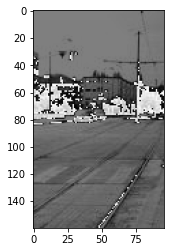

In [4]:
grayImg = convert_to_gray(img)
plt.imshow(grayImg, cmap='gray')

In [5]:
def convolution(imgInput, kernel):
    """Function to perform convolution on the image.
    Param : imgInput - input image (numpy array)
    kernel : filter / kernel (numpy array)
    Return : imgWithConvolution (numpy array)
    """
    ## get image size
    image_h = imgInput.shape[0]
    image_w = imgInput.shape[1]
    
    ## getting kernel shape    
    kernel_h = kernel.shape[0]
    kernel_w = kernel.shape[1]
    
    ## Calculate kernel half sizes for accomodating the border where kernel goes out of image bourndries
    h = kernel_h // 2
    w = kernel_w // 2
    
    ## Initialize output image with zero values
    image_conv = np.zeros(imgInput.shape)
    
    ## Perform convolution
    for i in range(h, image_h-h):        
        for j in range(w, image_w-w):
            x = imgInput[i-h:i-h+kernel_h, j-w:j-w+kernel_w]
            # multiply with the kernel
            
            x = x.flatten()*kernel.flatten()
            # assign mulitplied output of kernel to the pixel
            # print(x)
            image_conv[i][j] = x.sum()

    ## At the boundries where kernel goes out of image, set values as undefineed i.e. np.NaN
    # image_conv[:h,:] = np.NaN
    # image_conv[image_h-h:,:] = np.NaN
    # image_conv[:,:w] = np.NaN
    # image_conv[:,image_w-w:] = np.NaN
    image_conv[:h,:] = 0
    image_conv[image_h-h:,:] = 0
    image_conv[:,:w] = 0
    image_conv[:,image_w-w:] = 0
    
    # print(image_conv[0:2,0:2])
    # print(image_conv[h:h+2,w:w+2])
   

    return image_conv

In [6]:
filter_sobel_hor = np.array([[-1,-2,-1],
                             [0,0,0],
                             [1,2,1]])

filter_sobel_ver = np.array([[-1,0,1],
                             [-2,0,2],
                             [-1,0,1]])


#### Computing Gradients Gx and Gy

Text(0.5, 1.0, 'Vertical gradient Gy')

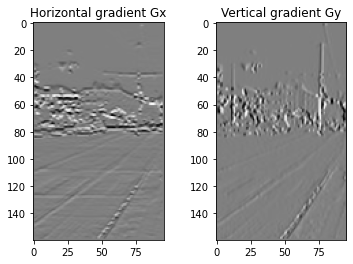

In [58]:
Gx = convolution(grayImg, filter_sobel_hor)
Gy = convolution(grayImg, filter_sobel_ver)

plt.subplot(1,2,1)
plt.imshow(Gx, cmap='gray')
plt.title("Horizontal gradient Gx")
plt.subplot(1,2,2)
plt.imshow(Gy, cmap='gray')
plt.title("Vertical gradient Gy")

In [59]:
### Assign mag and angle as 0 where Gx and Gy both are 0  ## remaining


In [60]:
def normalize_magnitude(mag):

    ## 1. Normalize gradient magnitude within range 0 to 255
    mag_normed = mag / np.max(mag) * 255

    ## 2. Convert to integers (round off)
    mag_normed = mag_normed.astype(np.uint8)
    return mag_normed

In [90]:
def quantize_unsigned(angle):        
    #### Subtract 180 if angle is within range [180,360)
    if angle > 180:  
        angle = angle - 180
    upperMargins = [20,40,60,80,100,120,140,160,180]
    bin_index = 8
    for i, upper in enumerate(upperMargins):
        if angle <upper:
            bin_index = i
            break
    return bin_index


In [62]:
def quantize_signed(angle, no_of_bins=9):
    bin_size = 360 / no_of_bins
    bin_index = int((angle+180) //bin_size)
    return bin_index

In [63]:
def create_grad_array(img):

    ## 1. Convert img to Gray
    grayImg = convert_to_gray(img)

    Gx = convolution(grayImg, filter_sobel_hor)
    Gy = convolution(grayImg, filter_sobel_ver)
    mag = (Gx**2 + Gy**2)**(1/2)
    grad_angle = np.arctan2(Gy,Gx)*(180/np.pi)

    return mag, grad_angle  

In [64]:
# Create histogram of gradients
def get_cell_histogram(quantized_angles, mag_cell, gradient_angles_cell):
    num_bins = 9
    histogram = np.zeros(num_bins, dtype=float)
    bin_centers = [10,30,50,70,90,110,130,150,170]

    for i, bin_index in enumerate(quantized_angles):
        angle = gradient_angles_cell[i]
        
        resp_weight = mag_cell[i]
        for j, center in enumerate(bin_centers):
            if j==0:
                ## If angle is <= 10 i.e last bin center add complete weight to first bin
                if angle <= bin_centers[j]:
                    histogram[0] +=resp_weight
                    break
            else:
                if angle < bin_centers[j] and angle>= bin_centers[j-1]:
                    dist_prev = angle - bin_centers[j-1]
                    dist_next = bin_centers[j] - angle
                    w0 = resp_weight * (dist_prev / 20)
                    w1 = resp_weight * (dist_next / 20)
                    # print(f"bin_centers[j-1] {bin_centers[j-1]} bin_centers[j] {bin_centers[j]} dist_prev {dist_prev} dist_next {dist_next} w0 {w0} w1 {w1}")

                    histogram[j-1] +=w0
                    histogram[j] +=w1
                    # print(histogram[j-1], histogram[j])

                    break
                
            if j ==8:
                ## If angle is > 170 i.e last bin center add complete weight to last bin 
                if angle>=bin_centers[j]:
                    histogram[j] +=resp_weight

                        
    return histogram

    # print(angle, resp_weight, bin_index)


In [91]:
def get_mag_grad_indices(image):
    magnitude, gradient = create_grad_array(image)

    ## 2. Normalize the magnitude and round off
    mag_normed = normalize_magnitude(magnitude)
    
    gradient = abs(gradient)
    f = lambda x : quantize_unsigned(x)
    
    # quantized_angles = np.apply(quantize_unsigned, gradient, axes=[0,1])
    shapeOrg = gradient.shape
    flattend = gradient.flatten()
    quantized_angles = f(flattend)

    quantized_angles = np.reshape(quantized_angles, shapeOrg)
    return mag_normed, gradient, quantized_angles

## Normalized HOG features

In [77]:
CELL_SIZE = 8
x1 = 0
x2 = x1+CELL_SIZE
y1 = 24
y2=y1+CELL_SIZE

In [78]:
grad_angle_cell = grad_angle_copy_positive[y1:y2, x1:x2].flatten()
mag_cell = mag_new[y1:y2, x1:x2].flatten()
quantized_angles = [quantize_unsigned(angle) for angle in grad_angle_cell]



In [79]:
histogram2 = get_cell_histogram(quantized_angles, mag_cell, grad_angle_cell)
histogram2

array([  1.20181217,   1.54818783,   3.16886667,   4.47839599,
         5.84204788,  17.64189347, 111.72648962,  87.44856969,
        62.94373668])

In [80]:
CELL_SIZE = 8
x1 = 0
x2 = x1+CELL_SIZE
y1 = 32
y2=y1+CELL_SIZE

In [81]:
grad_angle_cell = grad_angle_copy_positive[y1:y2, x1:x2].flatten()
mag_cell = mag_new[y1:y2, x1:x2].flatten()
quantized_angles = [quantize_unsigned(angle) for angle in grad_angle_cell]



In [82]:
histogram3 = get_cell_histogram(quantized_angles, mag_cell, grad_angle_cell)
histogram3

array([ 65.86793438, 270.8037227 , 280.57519587, 299.95513469,
       428.60488187, 268.38873264, 367.88378792, 349.73835124,
        39.18225869])

## Normalization over the block

In [83]:
def normalize_block(hist_cells):

    
    concat = np.concatenate(hist_cells)
    print(concat, concat.shape)
    ### L2 Normalization
    squared = np.square(concat)
    print("squared",squared) 
    normed = np.sqrt(squared)
    print("normed", normed, normed.shape)
    print(normed ==concat)
    return normed




In [84]:
CELL_SIZE = 8
STEP_SIZE = 8
def create_hog_features(grad_array,mag_array):
	max_h = int(((grad_array.shape[0]-CELL_SIZE)/STEP_SIZE)+1)
	max_w = int(((grad_array.shape[1]-CELL_SIZE)/STEP_SIZE)+1)
	cell_array = []
	w = 0
	h = 0
	i = 0
	j = 0

	#Creating 8X8 cells
	while i<max_h:
		w = 0
		j = 0

		while j<max_w:
			for_hist = grad_array[h:h+CELL_SIZE,w:w+CELL_SIZE]
			for_wght = mag_array[h:h+CELL_SIZE,w:w+CELL_SIZE]
			
			val = calculate_histogram(for_hist,for_wght)
			cell_array.append(val)
			j += 1
			w += incr[1]

		i += 1
		h += STEP_SIZE

	cell_array = np.reshape(cell_array,(max_h, max_w, bin_num))
	#normalising blocks of cells
	block = [2,2]
	#here increment is 1

	max_h = int((max_h-block[0])+1)
	max_w = int((max_w-block[1])+1)
	block_list = []
	w = 0
	h = 0
	i = 0
	j = 0

	while i<max_h:
		w = 0
		j = 0

		while j<max_w:
			for_norm = cell_array[h:h+block[0],w:w+block[1]]
			mag = np.linalg.norm(for_norm)
			arr_list = (for_norm/mag).flatten().tolist()
			block_list += arr_list
			j += 1
			w += 1

		i += 1
		h += 1

	#returns a vextor array list of 288 elements
	return block_list


In [92]:


mag_normed, gradient, quantized_angles = get_mag_grad_indices(img)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [95]:
## Histogram intersection
import numpy as np

def histogram_intersection(hist1, hist2):
    minima = np.minimum(hist1, hist2)
    intersection = np.true_divide(np.sum(minima), np.sum(hist2))
    return intersection

# Example histograms
hist1 = np.array([1, 2, 3, 4, 5])
hist2 = np.array([2, 3, 4, 5, 6])

# Calculate histogram intersection
intersection = histogram_intersection(hist1, hist2)
print("Histogram intersection:", intersection)

Histogram intersection: 0.75


In [96]:
## Helinger distance
import numpy as np

def hellinger_distance(p, q):
    # Calculate the square root of the element-wise product of p and q
    sqrt_pq = np.sqrt(np.multiply(p, q))
    # Calculate the Hellinger distance
    distance = np.sqrt(0.5 * np.sum((sqrt_pq - np.sqrt(p*q))**2))
    return distance

# Example probability distributions
p = np.array([0.2, 0.3, 0.5])
q = np.array([0.1, 0.5, 0.4])

# Calculate Hellinger distance
distance = hellinger_distance(p, q)
print("Hellinger distance:", distance)

Hellinger distance: 0.0
